### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
import itertools
import random

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [2]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')

train['year'] = train.date.dt.year
train['month'] = train.date.dt.month

# New Timeseries that is the aggregate of the sales for all products and all items in a month
ts_monthly = pd.Series(data = train.groupby(['year', 'month'])['sales'].sum().values)
ts_monthly.head()

0    454904
1    459417
2    617382
3    682274
4    763242
dtype: int64

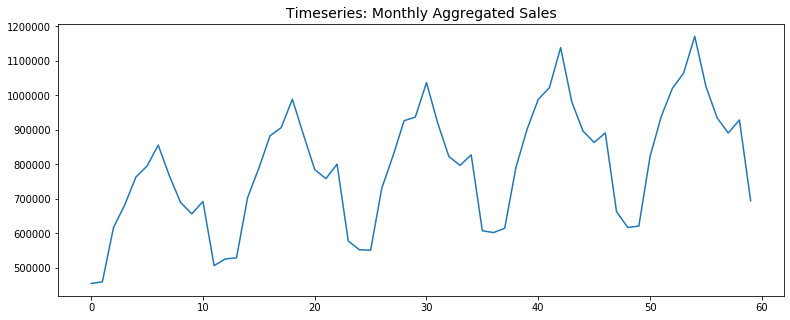

In [7]:
plt.figure(figsize = (13, 5))
plt.plot(ts_monthly.index, ts_monthly)
plt.title('Timeseries: Monthly Aggregated Sales', fontsize = 14)
plt.show()

#### Create Train, Validation and Test Subsets

<ol>
    <li>We divide the timeseries into three parts, 60% train subset, 20% validation subset and 20% test subset.
</ol>

In [24]:
train_idx = np.int(0.6*len(ts_monthly))
val_idx = np.int(0.8*len(ts_monthly))

#### Examining Stationarity, ACF & PACF plots and Existence of Autocorrelation in train subset

In [25]:
#Examining for Stationarity

result = adfuller(ts_monthly[:train_idx], regression = 'ct')  #'ct' because there is a trend in the timeseries
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -0.8653
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -4.3750
   5%        -3.6035
  10%        -3.2382

p-value: 9.5973e-01


#### Observations
The Augmented Dickey-Fuller (ADF) test confirms that the series is not stationary.

In [26]:
# Examining for Autocorrelation amongst terms of timeseries

result = acorr_ljungbox(ts_monthly[:train_idx], lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1     5.487822e-06
2     1.043596e-06
3     4.036040e-06
4     6.566279e-06
5     2.376441e-07
6     3.913625e-09
7     3.139729e-10
8     5.140199e-10
9     1.458282e-09
10    6.003078e-10
Name: lb_pvalue, dtype: float64


#### Observations
The Ljung-Box test confirms that there indeed exists auto correlation amongst the terms of the series.

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


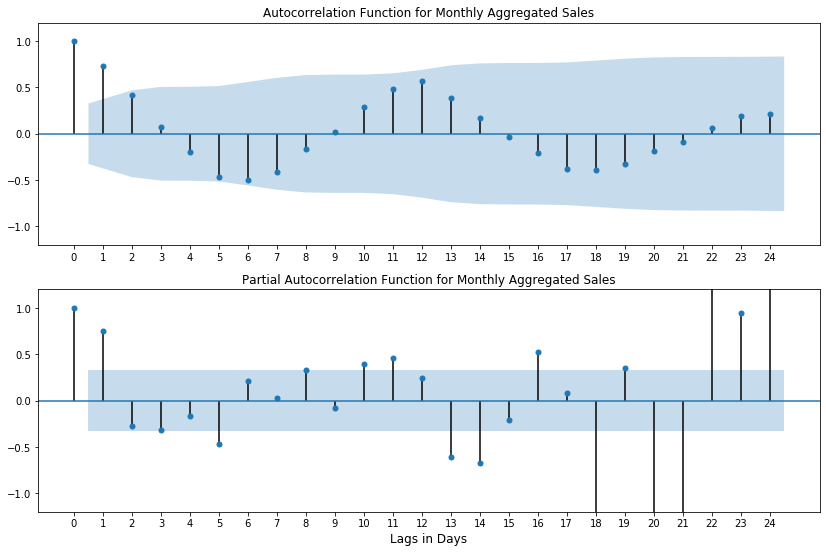

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))

tsaplots.plot_acf(ts_monthly[:train_idx], ax = ax1, alpha = 0.05, lags = 24,
                  title = 'Autocorrelation Function for Monthly Aggregated Sales')
tsaplots.plot_pacf(ts_monthly[:train_idx], ax = ax2, alpha = 0.05, lags = 24,
                   title = 'Partial Autocorrelation Function for Monthly Aggregated Sales')

ax1.set_xticks(np.arange(0, 25, 1))
ax1.set_ylim((-1.2, 1.2))
ax2.set_xticks(np.arange(0, 25, 1))
ax2.set_ylim((-1.2, 1.2))
ax2.set_xlabel('Lags in Days', fontsize = '12')

plt.show()

#### Observations
<ol>
    <li>From the ACF plot, meaningful peaks at lags 1, suggesting p = 1.
    <li>From the ACF plot, no meaningful peak at lag 12, but since the underlying series is a monthly series, suggesting P = 0, 1 and s = 0, 12.
    <li>From the PACF plot, meaningful peaks at lags 1, 5, 6, 10, 11, suggesting q = 1, (1, 5), (1, 5, 6), (1, 5, 6, 10), (1, 5, 6, 10, 11).
    <li>From the PACF plot meaningful peaks at lags 13, 14, 16, 18, 20, 21, 22, 23. Taking into account s = 12, this suggests Q = 1, (1, 6), (1, 6, 10), (1, 6, 10, 11)
    <li>The underlying trend in the series suggests d = 0, 1 and D = 0, 1
</ol>

#### Set up Configuration Grid Search

In [53]:
# Configuration options for model()
p = [1]
q = [1, (1, 5), (1, 5, 6), (1, 5, 6, 10), (1, 5, 6, 10, 11)]
d = [0, 1]
P = [0, 1]
Q = [1, (1, 6), (1, 6, 10), (1, 6, 10, 11)]
D = [0, 1]
s = [0, 12]
trend = ['n', 'c', 'ct', 'ctt']

"p = [1]\nq = [1]\nd = [0, 1]\nP = [0, 1]\nQ = [1]\nD = [0, 1]\ns = [0, 12]\ntrend = ['n']"

In [54]:
order = itertools.product(p, d, q)
seasonal_order = itertools.product(P, D, Q, s)
configs = itertools.product(order, seasonal_order, trend)
best_smape = 100
history = np.array(ts_monthly[:train_idx])
for config in configs:
    o, s_o, t = config
    try:
        model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
        fit = model.fit(disp = False, method = 'powell')
        y_hat = fit.predict(train_idx, val_idx - 1)
        y = ts_monthly[train_idx:val_idx]
        smape = np.mean(abs(y - y_hat)/(abs(y) + abs(y_hat)))*100
        if smape < best_smape:
            best_smape = smape
            best_config = config
    except:
        continue
        
o, s_o, t = best_config
print('The lowest SMAPE score achieved for the validation set = %.4f' % best_smape)
print('The parameters for the model with best SMAPE:')
print('order = %s, seasonal_order = %s, trend = %s' % best_config)


Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, 1, 0), trend = n
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, 1, 0), trend = c
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, 1, 0), trend = ct
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, 1, 0), trend = ctt
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ct


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 0, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = c
Fa

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6)), seasonal_order = (0, 0, (1

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 0, (1

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood o

Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5,

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 0, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 0, (1, 5,

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, 1, 0), trend = n
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, 1, 0), trend = c
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, 1, 0), trend = ct
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, 1, 0), trend = ctt
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6), 0), trend = ctt
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 1, 1), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ct


Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (0, 1, (1, 6, 10, 11), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (1, 0, 1, 0), trend = n
Failed building model for order = (1, 1, (1, 5)), seasonal_order = (1, 0, 1, 0), trend 

Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, 1, 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, 1, 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, 1, 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, 1, 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6)), seasonal_order = (1, 1, (1, 6), 0), tr

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, 1, 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, 1, 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, 1, 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, 1, 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10)), seasonal_order = (1, 1, (1

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 0, (1, 6, 10, 11), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, 1, 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (0, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5,

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 0, (1, 6, 10, 11), 0), trend = ctt


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, 1, 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = n
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = c
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = ct
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6), 0), trend = ctt
Failed building model for order = (1, 1, (1, 5, 6, 10, 11)), seasonal_order = (1, 1, (1, 6, 10), 0), trend = n
Failed building model for order = (1, 1, (1, 5,

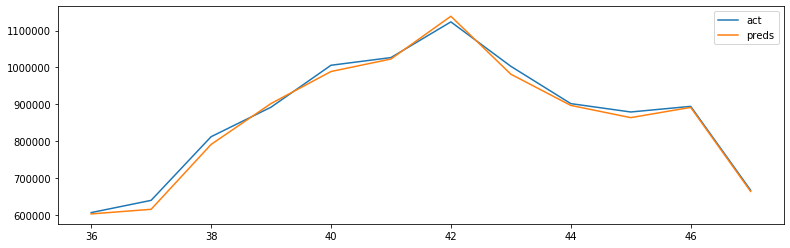

In [59]:
model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
fit = model.fit(disp = False, method = 'powell')
y_hat = fit.predict(train_idx, val_idx-1)
y = ts_monthly[train_idx:val_idx]

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index[train_idx:val_idx], y_hat, label = 'act')
plt.plot(ts_monthly.index[train_idx:val_idx], y, label = 'preds')
plt.legend()
plt.show()

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


The estimated test set SMAPE = 6.2086


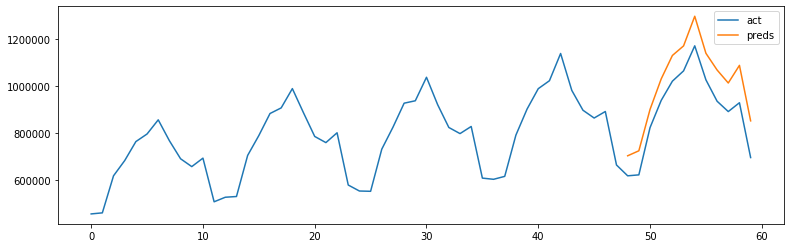

In [61]:
history = np.array(ts_monthly[:val_idx])

model = SARIMAX(history, order = o, seasonal_order = s_o, trend = t)
fit = model.fit(disp = False, method = 'powell')
y_hat = fit.predict(val_idx, len(ts_monthly) - 1)
y = ts_monthly[val_idx:]
smape = np.mean(abs(y - y_hat)/(abs(y) + abs(y_hat)))*100

print("The estimated test set SMAPE = %.4f" % smape)

plt.figure(figsize = (13, 4))
plt.plot(ts_monthly.index, ts_monthly, label = 'act')
plt.plot(ts_monthly.index[val_idx:], y_hat, label = 'preds')
plt.legend()
plt.show()